# Проект: классификация

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [100]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [101]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [102]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

df['job'].value_counts(normalize=True)

management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: job, dtype: float64

### Задание 3

In [103]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance'] = df['balance'].str.replace(',00', '')
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype(float)
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [104]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

balance_median = df['balance'].median()
df['balance'] = df['balance'].fillna(balance_median)
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [105]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

print('#######job')
print(df['job'].value_counts(normalize=True))
print('#######education')
print(df['education'].value_counts(normalize=True))

m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)

mode_balance = df[(df['job'] == m_job) & (df['education'] == m_edu)]['balance'].mean()
round(mode_balance, 3)

#######job
management       0.229887
blue-collar      0.174162
technician       0.163322
admin.           0.119513
services         0.082691
retired          0.069701
self-employed    0.036284
student          0.032252
unemployed       0.031984
entrepreneur     0.029385
housemaid        0.024548
unknown          0.006271
Name: job, dtype: float64
#######education
secondary    0.490593
tertiary     0.330496
primary      0.134385
unknown      0.044526
Name: education, dtype: float64


1598.883

### Задание 6

In [106]:
# удалите все выбросы для признака balance

x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)

df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print('lower_bound:', round(lower_bound), 'upper_bound:', round(upper_bound))
print('Количество объектов после удаления:', df.shape[0])

lower_bound: -2241 upper_bound: 4063
Количество объектов после удаления: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


<AxesSubplot: xlabel='deposit', ylabel='count'>

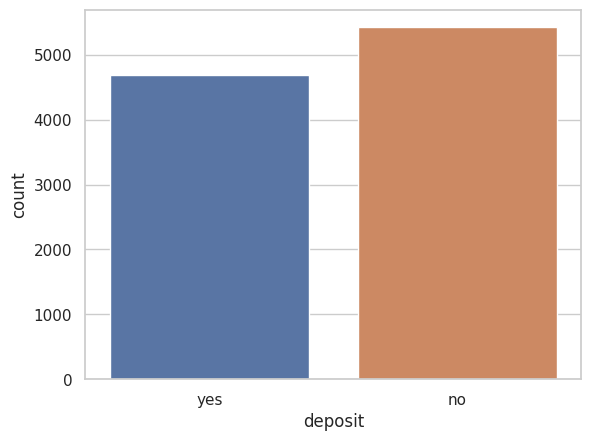

In [107]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

print(df['deposit'].value_counts())

sns.set_theme(style="whitegrid")
sns.countplot(x=df["deposit"])

Количество клиентов открывших и не открывших депозит примерно одинаково. Классы сбалансированы.

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


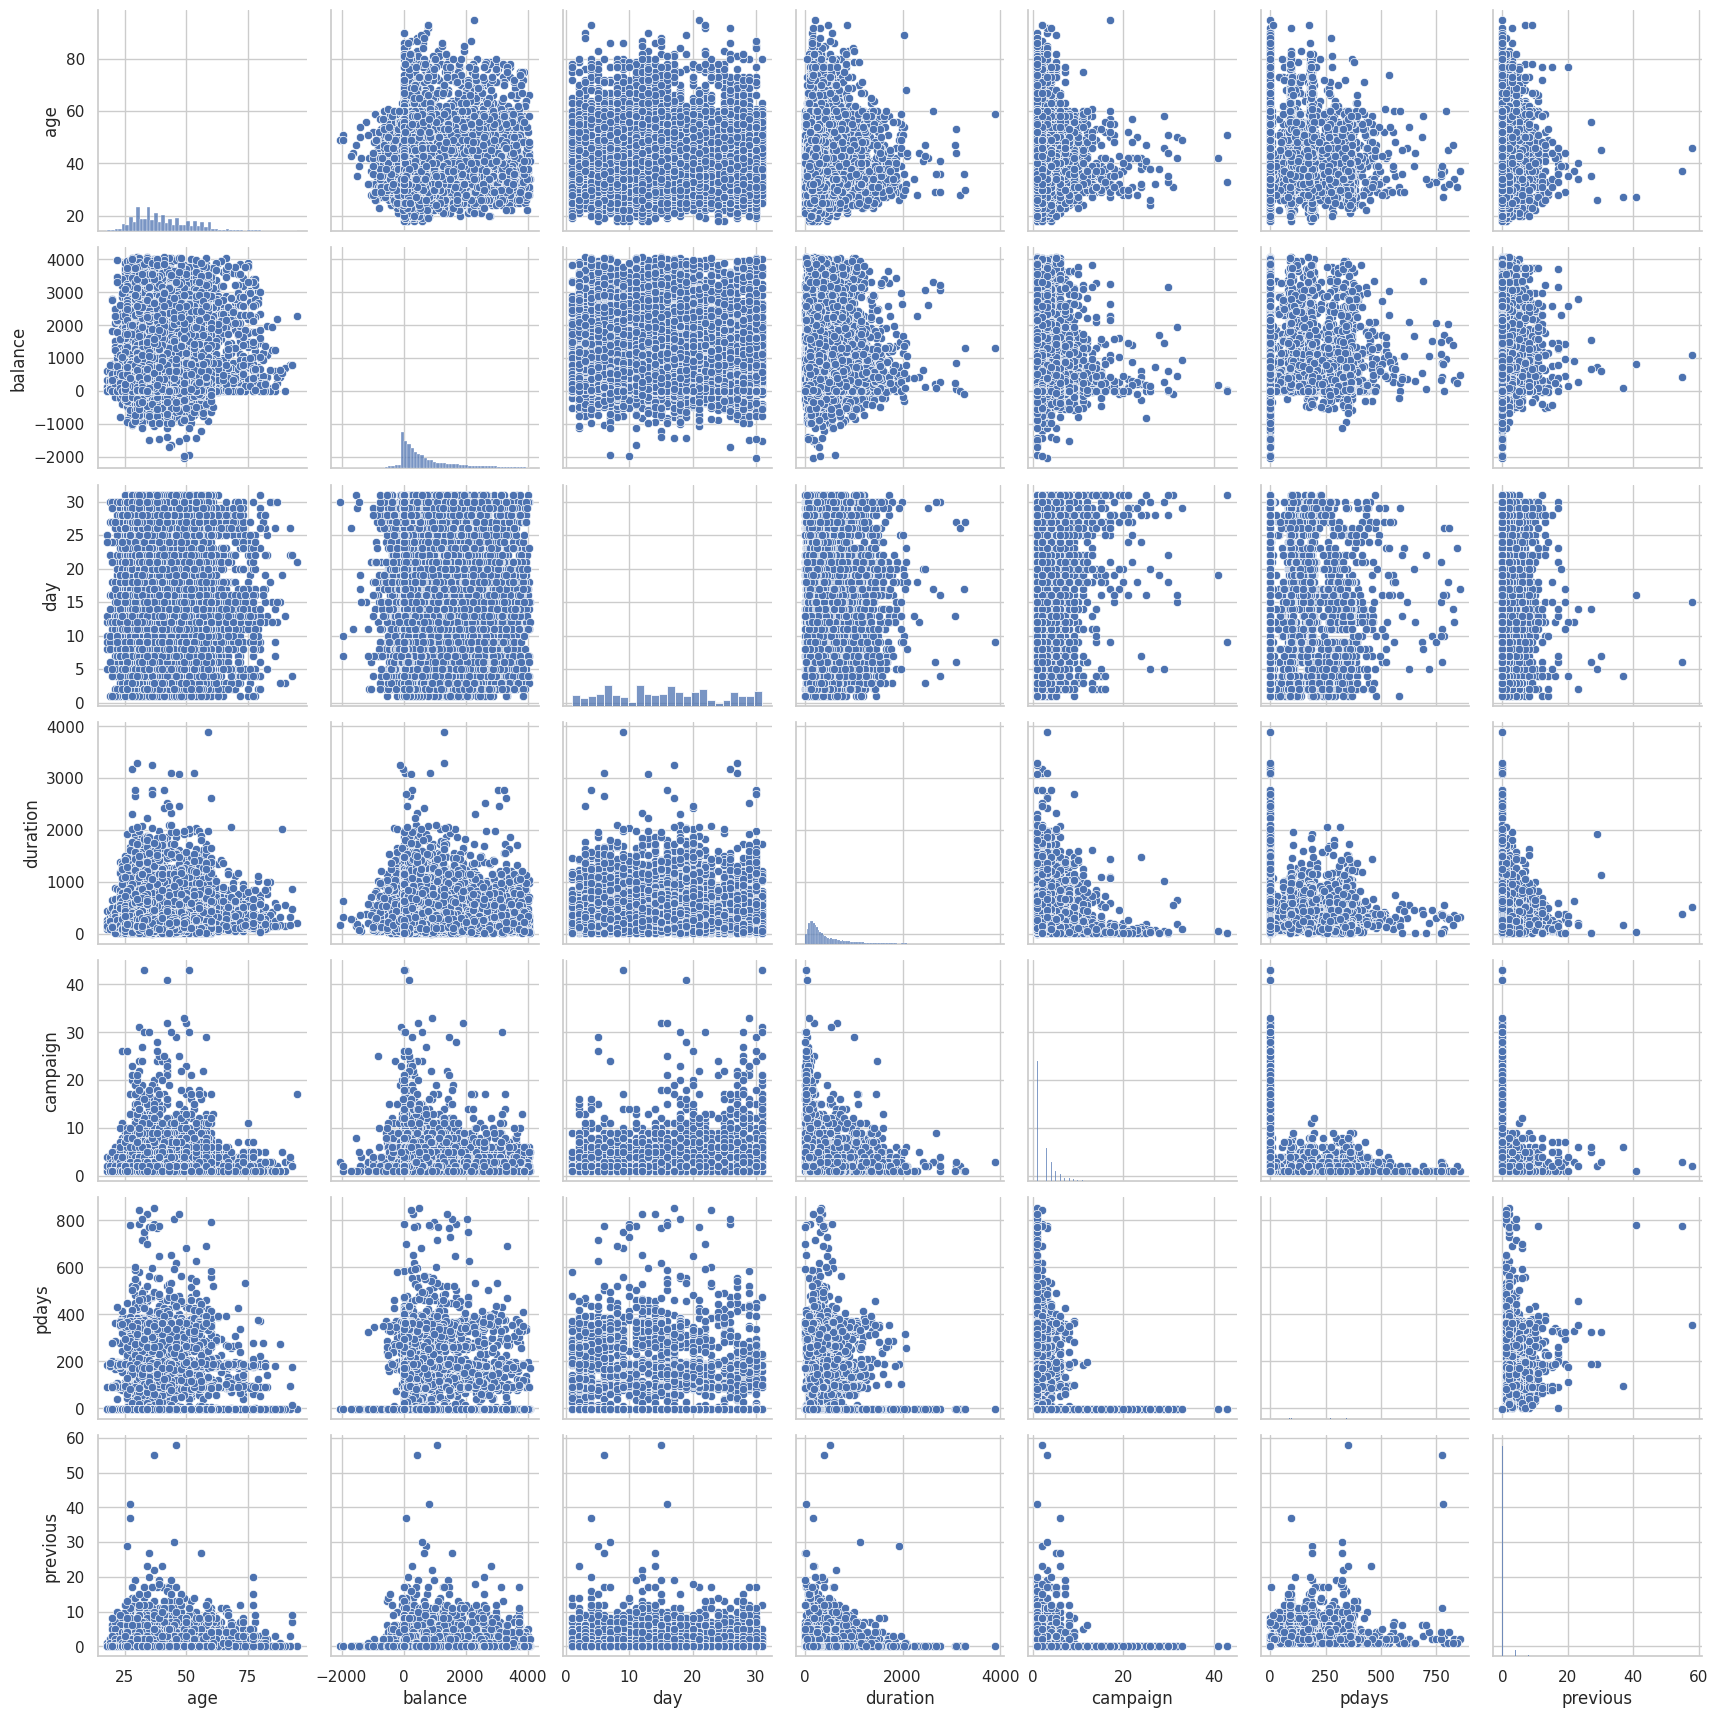

In [108]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

display(df.describe())

cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
sns_plot = sns.pairplot(df[cols])

В признаке duration (продолжительность разговора в секундах) максимальное значение 3881 это 65 минут, возможно это выброс.В признаке campaign (количество контактов с этим клиентом в течение текущей кампании) максимальное значение 43, возможно это выброс. В признаке balance (баланс) есть отрицательные значения. В данных прослеживается некоторая закономерность, чем старше человек тем больше у него баланс.

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


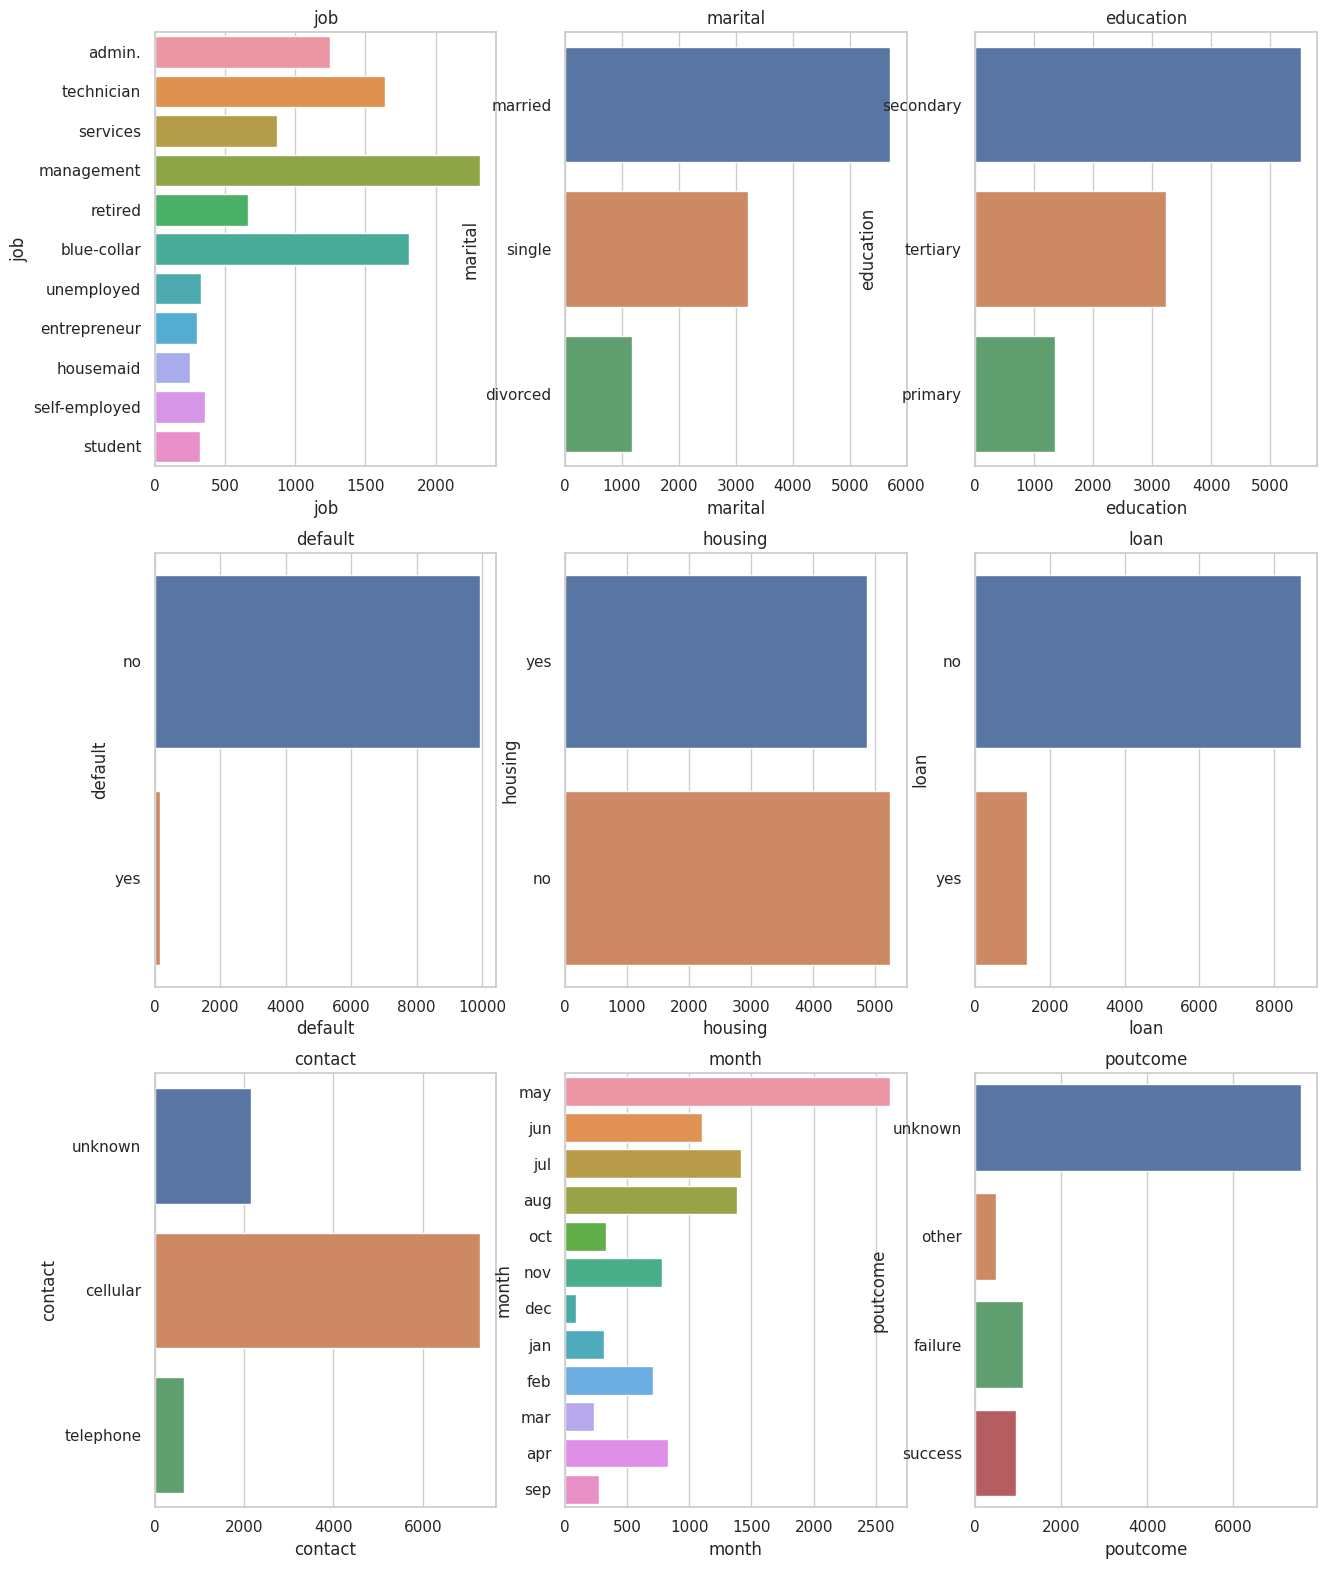

In [109]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

display(df.describe(include = 'object'))

categorical_features=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
import matplotlib.pyplot as plt
plt.figure(figsize=(15,80), facecolor='white')
plotnumber = 1
for categorical_feature in categorical_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.countplot(y=categorical_feature, data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
    
plt.show()



### Задание 6

<AxesSubplot: xlabel='poutcome'>

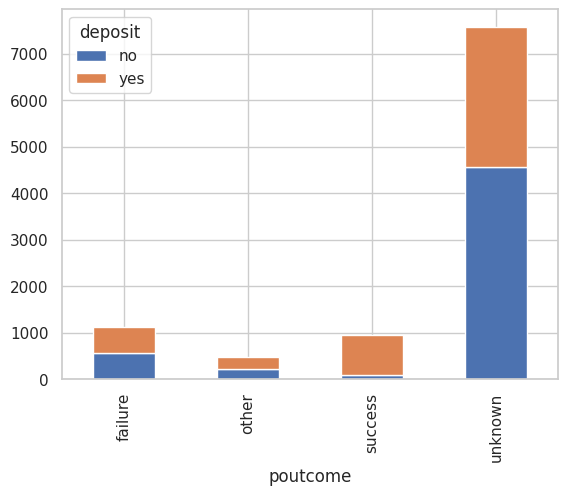

In [110]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
#print(df.groupby(by='poutcome').value_counts())

types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')



### Задание 7

In [111]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
res_n = df[df.deposit == 'no'].groupby(['month'])['deposit'].count()
res_k = df.groupby(['month'])['deposit'].count()
res_n/res_k

month
apr    0.381928
aug    0.559567
dec    0.096774
feb    0.455571
jan    0.608150
jul    0.589563
jun    0.548913
mar    0.101266
may    0.678640
nov    0.584615
oct    0.185075
sep    0.165468
Name: deposit, dtype: float64

### Задание 8

<AxesSubplot: xlabel='age_group', ylabel='count'>

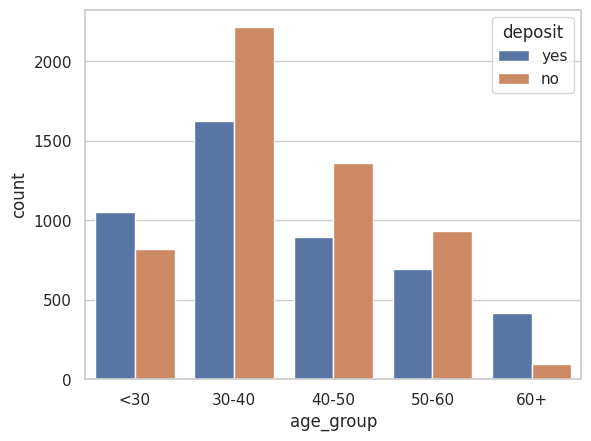

In [112]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

### Задания 9 и 10

<AxesSubplot: xlabel='count', ylabel='marital'>

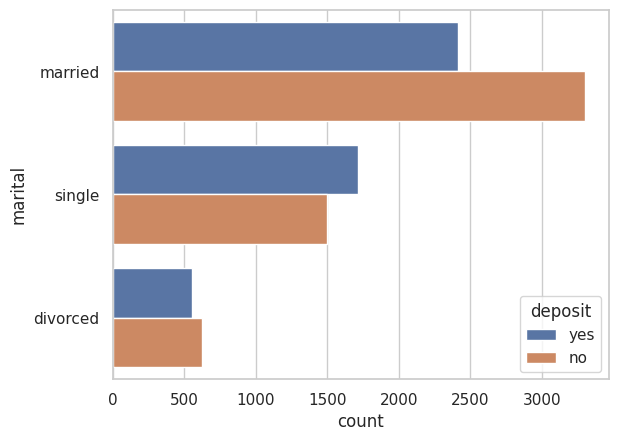

In [113]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=df)

<AxesSubplot: xlabel='count', ylabel='education'>

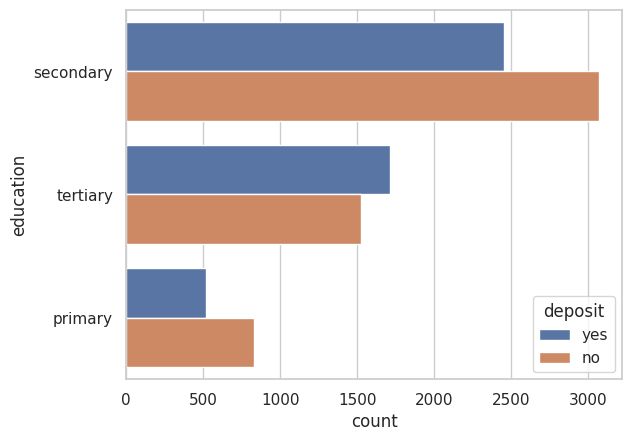

In [114]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=df)

<AxesSubplot: xlabel='count', ylabel='job'>

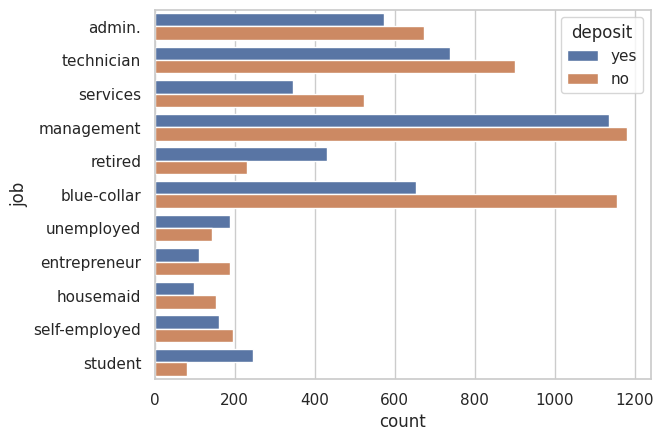

In [115]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=df)

### Задание 11

In [116]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
bank1 = df[df.deposit == 'yes'][['education','marital','deposit']]
bank2 = df[df.deposit == 'no'][['education','marital','deposit']] 
res1 = pd.crosstab(bank1['education'],bank1['marital'])
res2 = pd.crosstab(bank2['education'],bank2['marital'])
print(res1)
print(res2)

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755
marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531


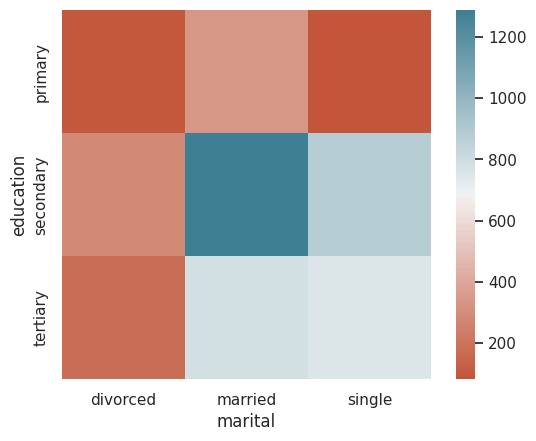

In [117]:
ax = sns.heatmap(
    res1, 
    #vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

## Часть 3: преобразование данных

### Задание 1

In [118]:
# преобразуйте уровни образования
lab_enc = LabelEncoder()

# Кодирование признака
df['education'] = lab_enc.fit_transform(df['education'])
print(df['education'].sum())

11995


### Задания 2 и 3

In [119]:
# преобразуйте бинарные переменные в представление из нулей и единиц
le = LabelEncoder()
df["age_group"] = le.fit_transform(df["age_group"])

def bin_func(row):
    if row == 'yes':
        return 1
    else:
        return 0

df['deposit'] = df['deposit'].apply(bin_func)

print('Стандартное отклонение deposit', df['deposit'].std())

df['default'] = df['default'].apply(bin_func)
df['housing'] = df['housing'].apply(bin_func)
df['loan'] = df['loan'].apply(bin_func)

res = df['default'].mean() + df['housing'].mean() + df['loan'].mean()
print('Среднее арифметическое', round(res, 3))

Стандартное отклонение deposit 0.4986712532452124
Среднее арифметическое 0.635


### Задание 4

In [120]:
# создайте дамми-переменные

categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df1= pd.get_dummies(df[categorial_features])
df = pd.concat([df,df1], axis = 1)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


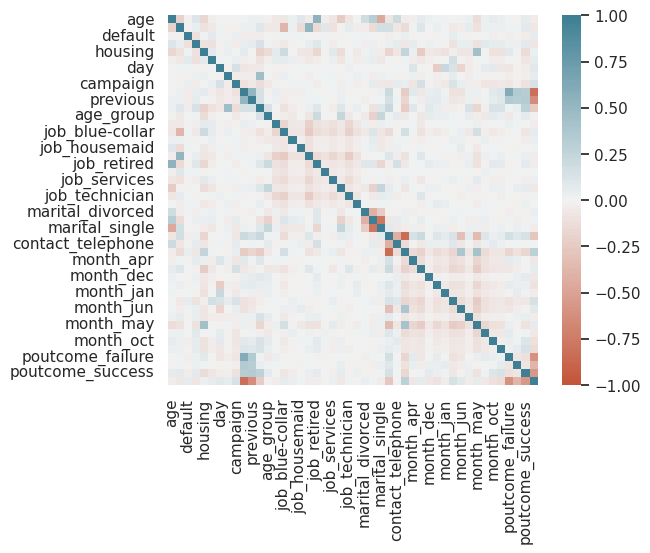

In [121]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

corr = df.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
display(sort_corr.head())


In [122]:
df['age'].corr(df['age_group'], method = 'pearson')
display(df[['age_group','age']])

,age_group,age
0,2,59
1,2,56
2,1,41
3,2,55
4,2,54
...,...,...
11157,0,33
11158,0,39
11159,0,32
11160,1,43


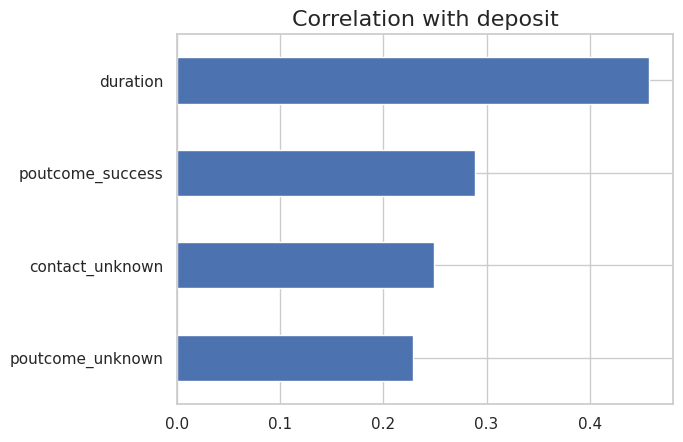

In [123]:
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()


### Задания 7 и 8

In [124]:
df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [125]:
# рассчитайте необходимые показатели

print(y_test.shape)
print(round(y_test.mean(), 2))

(3335,)
0.46


### Задание 9

In [126]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
select_k_best_classifier = SelectKBest(score_func=f_classif, k=15).fit(X_train, y_train)
select_k_best_classifier.get_support()
feature_names = list(X_train.columns.values)
mask = select_k_best_classifier.get_support()
new_features = []

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
new_features

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [127]:
# нормализуйте данные с помощью minmaxsxaler
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(round(X_test_scaled[:, 0].mean(), 2))  # для признака balance

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [128]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Test accuracy: 0.81


### Задания 2,3,4

In [129]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)

print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

y_test_pred = dt.predict(X_test_scaled)

print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))



Train: 0.82
Test: 0.81


In [130]:
from sklearn.model_selection import GridSearchCV
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
model_cv = GridSearchCV(tree.DecisionTreeClassifier(), parameters,
 cv=3, scoring=('f1'), return_train_score=True)
model_cv.fit(X_train_scaled, y_train)

print("Наилучшие значения параметров: {}".format(model_cv.best_params_))

y_test_pred = model_cv.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}
f1_score на тестовом наборе: 0.80
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [131]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [132]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print()
print('Train: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train: 0.86
Test accuracy: 0.83

Train: 0.86
Test recall: 0.83


### Задания 2 и 3

In [133]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)

print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = gb.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.88
Test: 0.82


### Задание 4

In [134]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
#print('Train: {:.2f}'.format(metrics.precision(y_train, y_train_pred)))
y_test_pred = stack.predict(X_test_scaled)
#print('Test: {:.2f}'.format(metrics.precision(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [135]:
estimators = [
('dtc', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),
('rf', ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)),
('gb', ensemble.GradientBoostingClassifier(min_samples_leaf=5, learning_rate=0.05, n_estimators=300, max_depth=5, random_state=42))
]
#Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

#Обучаем модель
reg.fit(X_train_scaled, y_train)

# Выводим значения метрики
y_train_pred = reg.predict(X_train_scaled)
print('F1 Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = reg.predict(X_test_scaled)
print('F1 Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 Train: 0.86
F1 Test: 0.81


### Задание 5

Feature: 0, Score: 0.05795
Feature: 1, Score: 0.04773
Feature: 2, Score: 0.50711
Feature: 3, Score: 0.01478
Feature: 4, Score: 0.05508
Feature: 5, Score: 0.00846
Feature: 6, Score: 0.03990
Feature: 7, Score: 0.00359
Feature: 8, Score: 0.07261
Feature: 9, Score: 0.02782
Feature: 10, Score: 0.01521
Feature: 11, Score: 0.01988
Feature: 12, Score: 0.01353
Feature: 13, Score: 0.11496
Feature: 14, Score: 0.00140


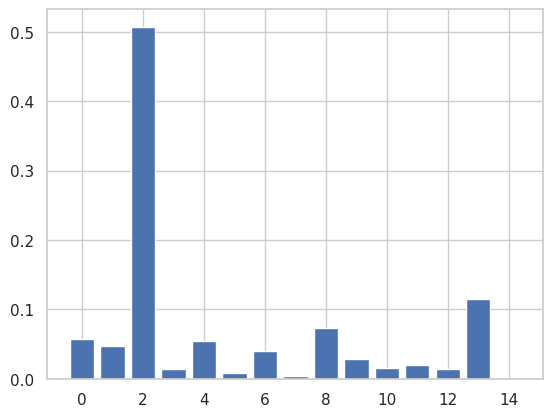

In [136]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

import matplotlib.pyplot  as plt
importance = gb.feature_importances_
for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Задания 6,7,8

In [137]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))


[I 2023-03-16 11:29:39,158] A new study created in memory with name: no-name-239899e1-0235-4b50-869f-bd6b55500898
[I 2023-03-16 11:29:39,819] Trial 0 finished with value: 0.8486934751994993 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8486934751994993.
[I 2023-03-16 11:29:40,746] Trial 1 finished with value: 0.8534832864729772 and parameters: {'n_estimators': 183, 'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8486934751994993.
[I 2023-03-16 11:29:41,520] Trial 2 finished with value: 0.8612110780785479 and parameters: {'n_estimators': 152, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8486934751994993.
[I 2023-03-16 11:29:42,506] Trial 3 finished with value: 0.8588400812881039 and parameters: {'n_estimators': 196, 'max_depth': 13, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8486934751994993.
[I 2023-03-16 11:29:43,353] Trial 4 finished with value: 0.869864083736916

accuracy на тестовом наборе: 0.825
f1_score на тестовом наборе: 0.815


In [138]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42
                                          )
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)


[I 2023-03-16 11:29:53,772] A new study created in memory with name: RandomForestClassifier
[I 2023-03-16 11:29:54,436] Trial 0 finished with value: 0.8587041373926619 and parameters: {'n_estimators': 124, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8587041373926619.
[I 2023-03-16 11:29:55,136] Trial 1 finished with value: 0.8455743879472695 and parameters: {'n_estimators': 142, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8587041373926619.
[I 2023-03-16 11:29:55,677] Trial 2 finished with value: 0.8505388099328439 and parameters: {'n_estimators': 105, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8587041373926619.
[I 2023-03-16 11:29:56,670] Trial 3 finished with value: 0.8843921568627452 and parameters: {'n_estimators': 173, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8843921568627452.
[I 2023-03-16 11:29:57,260] Trial 4 finished with value: 0.8506716651046549 and parameters: {'n